In [13]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [14]:
class MyConvLayer(nn.Module):
	def __init__(self, in_channels=1, out_channels=1, kernel_size=(1,1), stride=1, padding=0):
		super().__init__()

		assert in_channels > 0 and out_channels > 0
		assert kernel_size[0] > 0 and kernel_size[1] > 0
		assert stride > 0
		assert padding >= 0

		self.in_channels = in_channels
		self.out_channels = out_channels
		self.p , self.q = kernel_size
		self.stride = stride
		self.padding = padding
		
		self.kern = nn.Parameter(torch.rand(kernel_size))
		
	def forward(self, X):
		print("Input shape: ", X.shape)
		print("Padding: ", self.padding)
		print("Stride: ", self.stride)

		# Output calculation: https://cs231n.github.io/convolutional-networks/
		new_height = (X.size(1) - self.p + (self.padding*2) + 1)/self.stride
		new_width = (X.size(2) - self.q + (self.padding*2 + 1))/self.stride
		
		# If the width or height is not whole number, we don't try and convert it to int. Instead this is logical error.
		assert new_height.is_integer()
		assert new_width.is_integer()

		output = torch.zeros(X.size(0), self.out_channels, int(new_height), int(new_width))

		# Pad
		X2 = X.clone()
		X2 = torch.cat((torch.zeros((1, self.padding, X2.shape[2])), X2), dim=1) # Top
		X2 = torch.cat((torch.zeros((1, X2.shape[1], self.padding)), X2), dim=2) # Left
		X2 = torch.cat((X2, torch.zeros((1, X2.shape[1], self.padding))), dim=2) # Right
		X2 = torch.cat((X2, torch.zeros((1, self.padding, X2.shape[2]))), dim=1) # Bottom
		
		print("Image after pad: ", X.shape)
		print("Output shape: ", output.shape)

		for i in range(output.size(1)):
			for j in range(output.size(2)):
				sub_img = X2[:, (i * self.stride):((i * self.stride) + self.p), (j * self.stride):((j * self.stride) + self.q)]
				#print(f"sub image: ({i}:{i+self.p},{j}:{j+self.q})")
				output[:, i, j] = (sub_img*self.kern).sum(dim=(1,2))

		return output

# Define sobel kernels

In [15]:
positive_X_sobel = torch.tensor([[1, 0, -1],
                                 [2, 0, -2],
                                 [1, 0, -1]])

negative_X_sobel = torch.tensor([[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]])

negative_Y_sobel = torch.tensor([[1, 2, 1],
                                 [0, 0, 0],
                                 [-1, -2, -1]])

positive_Y_sobel = torch.tensor([[-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]])

# Get sample image from Fashion MINST

In [16]:
train_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=1)
img, _ = next(iter(train_dataloader))

# Regular conv

torch.Size([1, 1, 28, 28])
Input shape:  torch.Size([1, 28, 28])
Padding:  0
Stride:  1
Image after pad:  torch.Size([1, 28, 28])
Output shape:  torch.Size([1, 1, 26, 26])


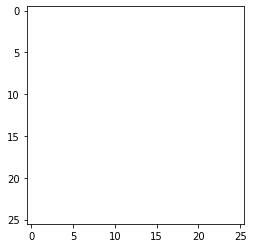

In [17]:
myConvLayer = MyConvLayer(kernel_size=(3,3))
myConvLayer.kern.requires_grad=False

print(img.shape)

myConvLayer.kern[:] = positive_X_sobel
img2= myConvLayer(img.reshape(1,28,28))

plt.imshow(img2.detach().squeeze(),cmap='Greys')

# Padding

Input shape:  torch.Size([1, 28, 28])
Padding:  14
Stride:  1
Image after pad:  torch.Size([1, 28, 28])
Output shape:  torch.Size([1, 1, 54, 54])


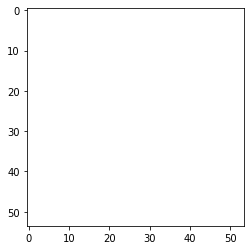

In [18]:
myConvLayer = MyConvLayer(kernel_size=(3,3), padding=14)
myConvLayer.kern.requires_grad=False

myConvLayer.kern[:] = positive_X_sobel
img2= myConvLayer(img.reshape(1,28,28))
plt.imshow(img2.detach().squeeze(),cmap='Greys')

# Stride

torch.Size([1, 1, 28, 28])
Input shape:  torch.Size([1, 28, 28])
Padding:  0
Stride:  2
Image after pad:  torch.Size([1, 28, 28])
Output shape:  torch.Size([1, 1, 13, 13])


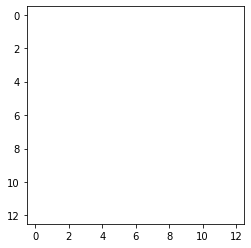

In [19]:
myConvLayer = MyConvLayer(kernel_size=(3,3), stride=2)
myConvLayer.kern.requires_grad=False

myConvLayer.kern[:] = positive_X_sobel
print(img.shape)
img2 = myConvLayer(img.reshape(1,28,28))
plt.imshow(img2.detach().squeeze(),cmap='Greys')

# Padding tensors example

In [20]:
img = torch.ones((1, 5, 5))

padding = 2

print("Top:", torch.cat((torch.zeros((1, padding, 5)), img), dim=1)) # Top

print("Left: ", torch.cat((torch.zeros((1, 5, padding)), img), dim=2)) # Left

print("Right: ", torch.cat((img, torch.zeros((1, 5, padding))), dim=2)) # Right

print("Bottom: ", torch.cat((img, torch.zeros((1, padding, 5))), dim=1)) # Bottom


Top: tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])
Left:  tensor([[[0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.]]])
Right:  tensor([[[1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.]]])
Bottom:  tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])


# Multi channel

X.shape:  torch.Size([28, 28, 3])
Input shape:  torch.Size([3, 28, 28])
Padding:  1
Stride:  2


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 3 for tensor number 1 in the list.

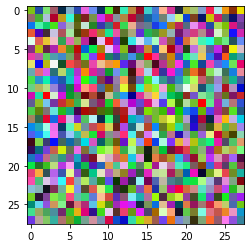

In [21]:
in_channels = 3
width = 28
height = 28
kernel_size = (3,3)
stride = 2
padding = 1
out_channels = 1

torch.manual_seed(0)
X = torch.rand(height, width, in_channels)
print("X.shape: ", X.shape)
plt.imshow(X,cmap='Greys')

myConvLayer = MyConvLayer(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
myConvLayer.kern.requires_grad=False
myConvLayer.kern[:] = positive_X_sobel


Y = myConvLayer(X.permute(2, 0, 1))

# Plot miage
plt.imshow(Y, cmap='Greys')